In [2]:
import sys
sys.path.append(r'f:\GraduateStudent')

import torch
from Projects.Model.NN import Transformer
from Projects.Utils.tools import *
import torch.nn as nn
import torch.optim as optim

device = utils_getDevice()

Using device: cuda


### 一、Transformer组件  

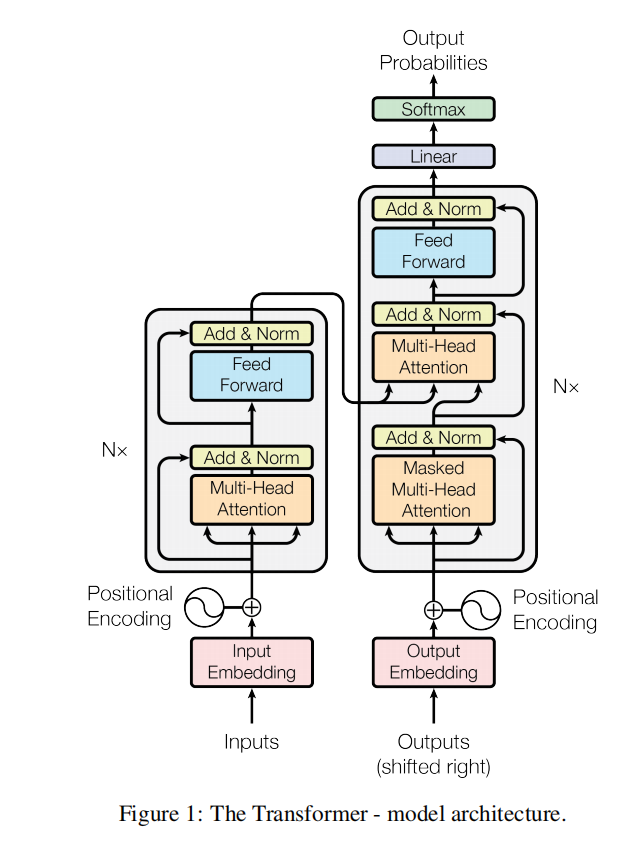  

主要部件：  
- Word Embedding + Positional Encoding  
- **(Masked) Multi-Head Attention**  
- Feed Forward  

#### 1. word embedding + positional encoding（词嵌入+位置编码）
**Word Embedding:**  

目的：将token ID在d_model维空间中通过向量表示。  

为补偿位置编码（PE）与词嵌入之间固有的幅值差异，原始 Transformer 在嵌入层输出处引入缩放因子 $\sqrt{d_{\text{model}}}$，即：

$$
\mathbf{X}_{\text{emb}} = \sqrt{d_{\text{model}}} \cdot \mathbf{E} \cdot \mathbf{I}
$$

其中：
- $\mathbf{E} \in \mathbb{R}^{|V| \times d_{\text{model}}}$：**词嵌入矩阵**（可学习参数）  
- $\mathbf{I} \in \mathbb{N}^{L}$：输入 token ID 序列（长度为 $L$），经 one-hot 展开后等价于查表操作  
- $d_{\text{model}} = 512$：模型维度（原始配置）

$\mathbf{E}$ 通常采用 Xavier/Glorot 初始化（或其他零均值初始化），其元素满足：
  $$
  \mathbb{E}[w] = 0, \quad \text{Var}(w) = \frac{1}{d_{\text{model}}}
  $$

对任意 token $i$，其查表所得嵌入向量 $\mathbf{e}_i = \mathbf{E}[I_i, :] \in \mathbb{R}^{d_{\text{model}}}$ 满足：
  $$
  \mathbb{E}\!\left[\|\mathbf{e}_i\|^2\right] = d_{\text{model}} \cdot \frac{1}{d_{\text{model}}} = 1
  \quad \Rightarrow \quad
  \mathbb{E}\!\left[\|\mathbf{e}_i\|\right] \approx 1
  $$

而正弦位置编码 $PE_{\text{pos}}$ 的每个维度为 $\sin(\cdot)$ 或 $\cos(\cdot)$，取值 $\in [-1, 1]$，其能量为：
  $$
  \mathbb{E}\!\left[\|PE_{\text{pos}}\|^2\right] 
  = \sum_{k=0}^{d_{\text{model}}-1} \mathbb{E}[PE_k^2] 
  = d_{\text{model}} \cdot \frac{1}{2}
  \quad \Rightarrow \quad
  \|PE_{\text{pos}}\| \approx \sqrt{\frac{d_{\text{model}}}{2}}
  $$

当 $d_{\text{model}} = 512$ 时：
  $$
  \frac{\|PE\|^2}{\|\mathbf{e}\|^2} \approx \frac{256}{1} = 256
  $$
  → 未经缩放的词嵌入能量仅为位置编码的约 **0.4%**，语义信息极易被位置信号淹没。

引入 $\sqrt{d_{\text{model}}}$ 后，嵌入输出变为：
$$
\tilde{\mathbf{e}}_i = \sqrt{d_{\text{model}}} \cdot \mathbf{e}_i
\quad \Rightarrow \quad
\mathbb{E}\!\left[\|\tilde{\mathbf{e}}_i\|^2\right] = d_{\text{model}}
$$

此时：
$$
\frac{\|\tilde{\mathbf{e}}_i\|^2}{\|PE_{\text{pos}}\|^2} \approx \frac{d_{\text{model}}}{d_{\text{model}}/2} = 2
$$

→ 词嵌入与位置编码的能量处于**同一数量级**（语义略强），确保二者在相加时（$\mathbf{X} = \mathbf{X}_{\text{emb}} + \mathbf{PE}$）贡献均衡，有利于模型联合学习语义与位置信息。

> 📌 论文原文（Sec 3.4）：*“In the embedding layers, we multiply the weights by $\sqrt{d_{\text{model}}}$.”*

**Positional Encoding:**

论文中Positional Encoding计算公式：

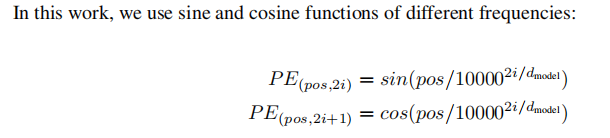

- 目的：为token注入位置信息，包含多个级别的位置信息，例如：“词级”、“段级”和“文章级”位置信息。
- 实现：通过“低频”、“高频”的正弦信号组合，改变token的d_model维度的数据，例如：“词级”信息通过d_model中的前部数据反映，“段级”信息通过d_model中的中部数据反映，“文章级”信息通过d_model中的尾部数据反映。
- 解释：“词级”包含主谓关系等语法信息（10词内）；“段级”包含逻辑连接（Although…, …；Therefore… 引导的因果/转折）（100词左右）；“文章级”包含在文章的开头、中间、结尾等位置信息（1000词左右）

选择sin、cos函数：
- 目的：摆脱绝对位置的依赖，依靠相对位置进行学习
- 实现、解释：

![alt text](1a247cd29be3f50f0398b4ec631a0854.jpg)

具体实现：  

![alt text](微信图片_20251109125728_133_3.jpg)  


In [ ]:
class WordEmbedding(nn.Module):
  '''
    将输入的seq_len个 词编号(token ID) 转换成对应的seq_len x d_model位浮点数 
  '''
  def __init__(self, vocab_size, d_model, padding_idx=0):
    '''
      params:
        vocab_size - 词汇表的大小
        d_model - 嵌入维度
        padding_idx - 填充token的索引
    '''
    super().__init__()
    self.embedding = nn.Embedding(
      vocab_size,
      d_model,
      padding_idx=padding_idx
    )
    self.d_model = d_model
    self._init_weights()

  def _init_weights(self):
    nn.init.xavier_uniform_(self.embedding.weight)    # 使用 Xavier均匀分布 初始化self.embedding的权重
    if self.embedding.padding_idx is not None:
      with torch.no_grad():
        self.embedding.weight[self.embedding.padding_idx].fill_(0)

  def forward(self, x):
    '''
      params:
        x - 输入token ids, [batch_size, seq_len]
      return:
        embeddings - [batch_size, seq_len, d_model]
    '''
    return self.embedding(x)*math.sqrt(self.d_model)

class PositionalEncoding(nn.Module):
  '''
    给输入的[seq_len x d_model]位浮点数添加位置信息
  '''
  def __init__(self, d_model, max_seq_length=512, dropout=0.1):
    '''
      params:
        d_model - 模型的嵌入维度，同词嵌入维度
        max_seq_length - 支持的最大序列长度
        dropout - 对加入位置编码后的结果应用 dropout
    '''
    super().__init__()
    self.dropout = nn.Dropout(p=dropout)
    pe = torch.zeros(max_seq_length, d_model) # [max_seq_length, d_model]
    position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)  # [max_seq_length, 1]
    div_term = torch.exp(torch.arange(0, d_model, 2).float()*
                         (-math.log(10000.0)/d_model))    # [d_model/2]
    # position*div_term -> [max_seq_length, d_model/2]

    pe[:, 0::2] = torch.sin(position*div_term)    # 偶数列(0, 2, ...)
    pe[:, 1::2] = torch.cos(position*div_term)    # 奇数列(1, 3, ...)

    pe = pe.unsqueeze(0)    # 添加batch维度，[1, max_seq_length, d_model]
    self.register_buffer('pe', pe)    # 将pe注册为模型的缓冲区，而不是可学习参数

  def forward(self, x):
    '''
      params:
        x - 输入张量 [batch_size, seq_len, d_model]
    '''
    x = x+self.pe[:, :x.size(1)]
    return self.dropout(x)


#### 2. (Masked) Multi-Head Attention
要了解多头注意力机制，首先要了解单头注意力机制。  
原论文中使用了 **`Scaled Dot-Product Attention`**（缩放点积注意力机制），它属于单头注意力机制的一种典型实现。  
而要理解缩放点积注意力机制，需先理解基础的 **`Attention`**（注意力机制）。

理解路线：  
`Attention` → `Scaled Dot-Product Attention` → **Self-Attention** → **Multi-Head Attention** → **Masked Multi-Head Attention**

- **Attention 举例** 
  给定 Q、K、V：K、V 代表目前已知的“键值”“价值”，即 `[1, 2]` 对应的价值为 `[50, 180]`；Q 代表要“询问”的向量，即 `[7, 8]` 对应的 V 应该是什么。

  举例说明：Q、K 的列分别代表“腰围”“臀围”，V 的列分别代表“体重”“身高”。  
  `f(Q, K)` 代表 Q 和 K 的相关性“得分”，“得分”越高，相关性越强；将 softmax 后的得分与 V 相乘，便可估算出 Q 对应的 `V'`。

  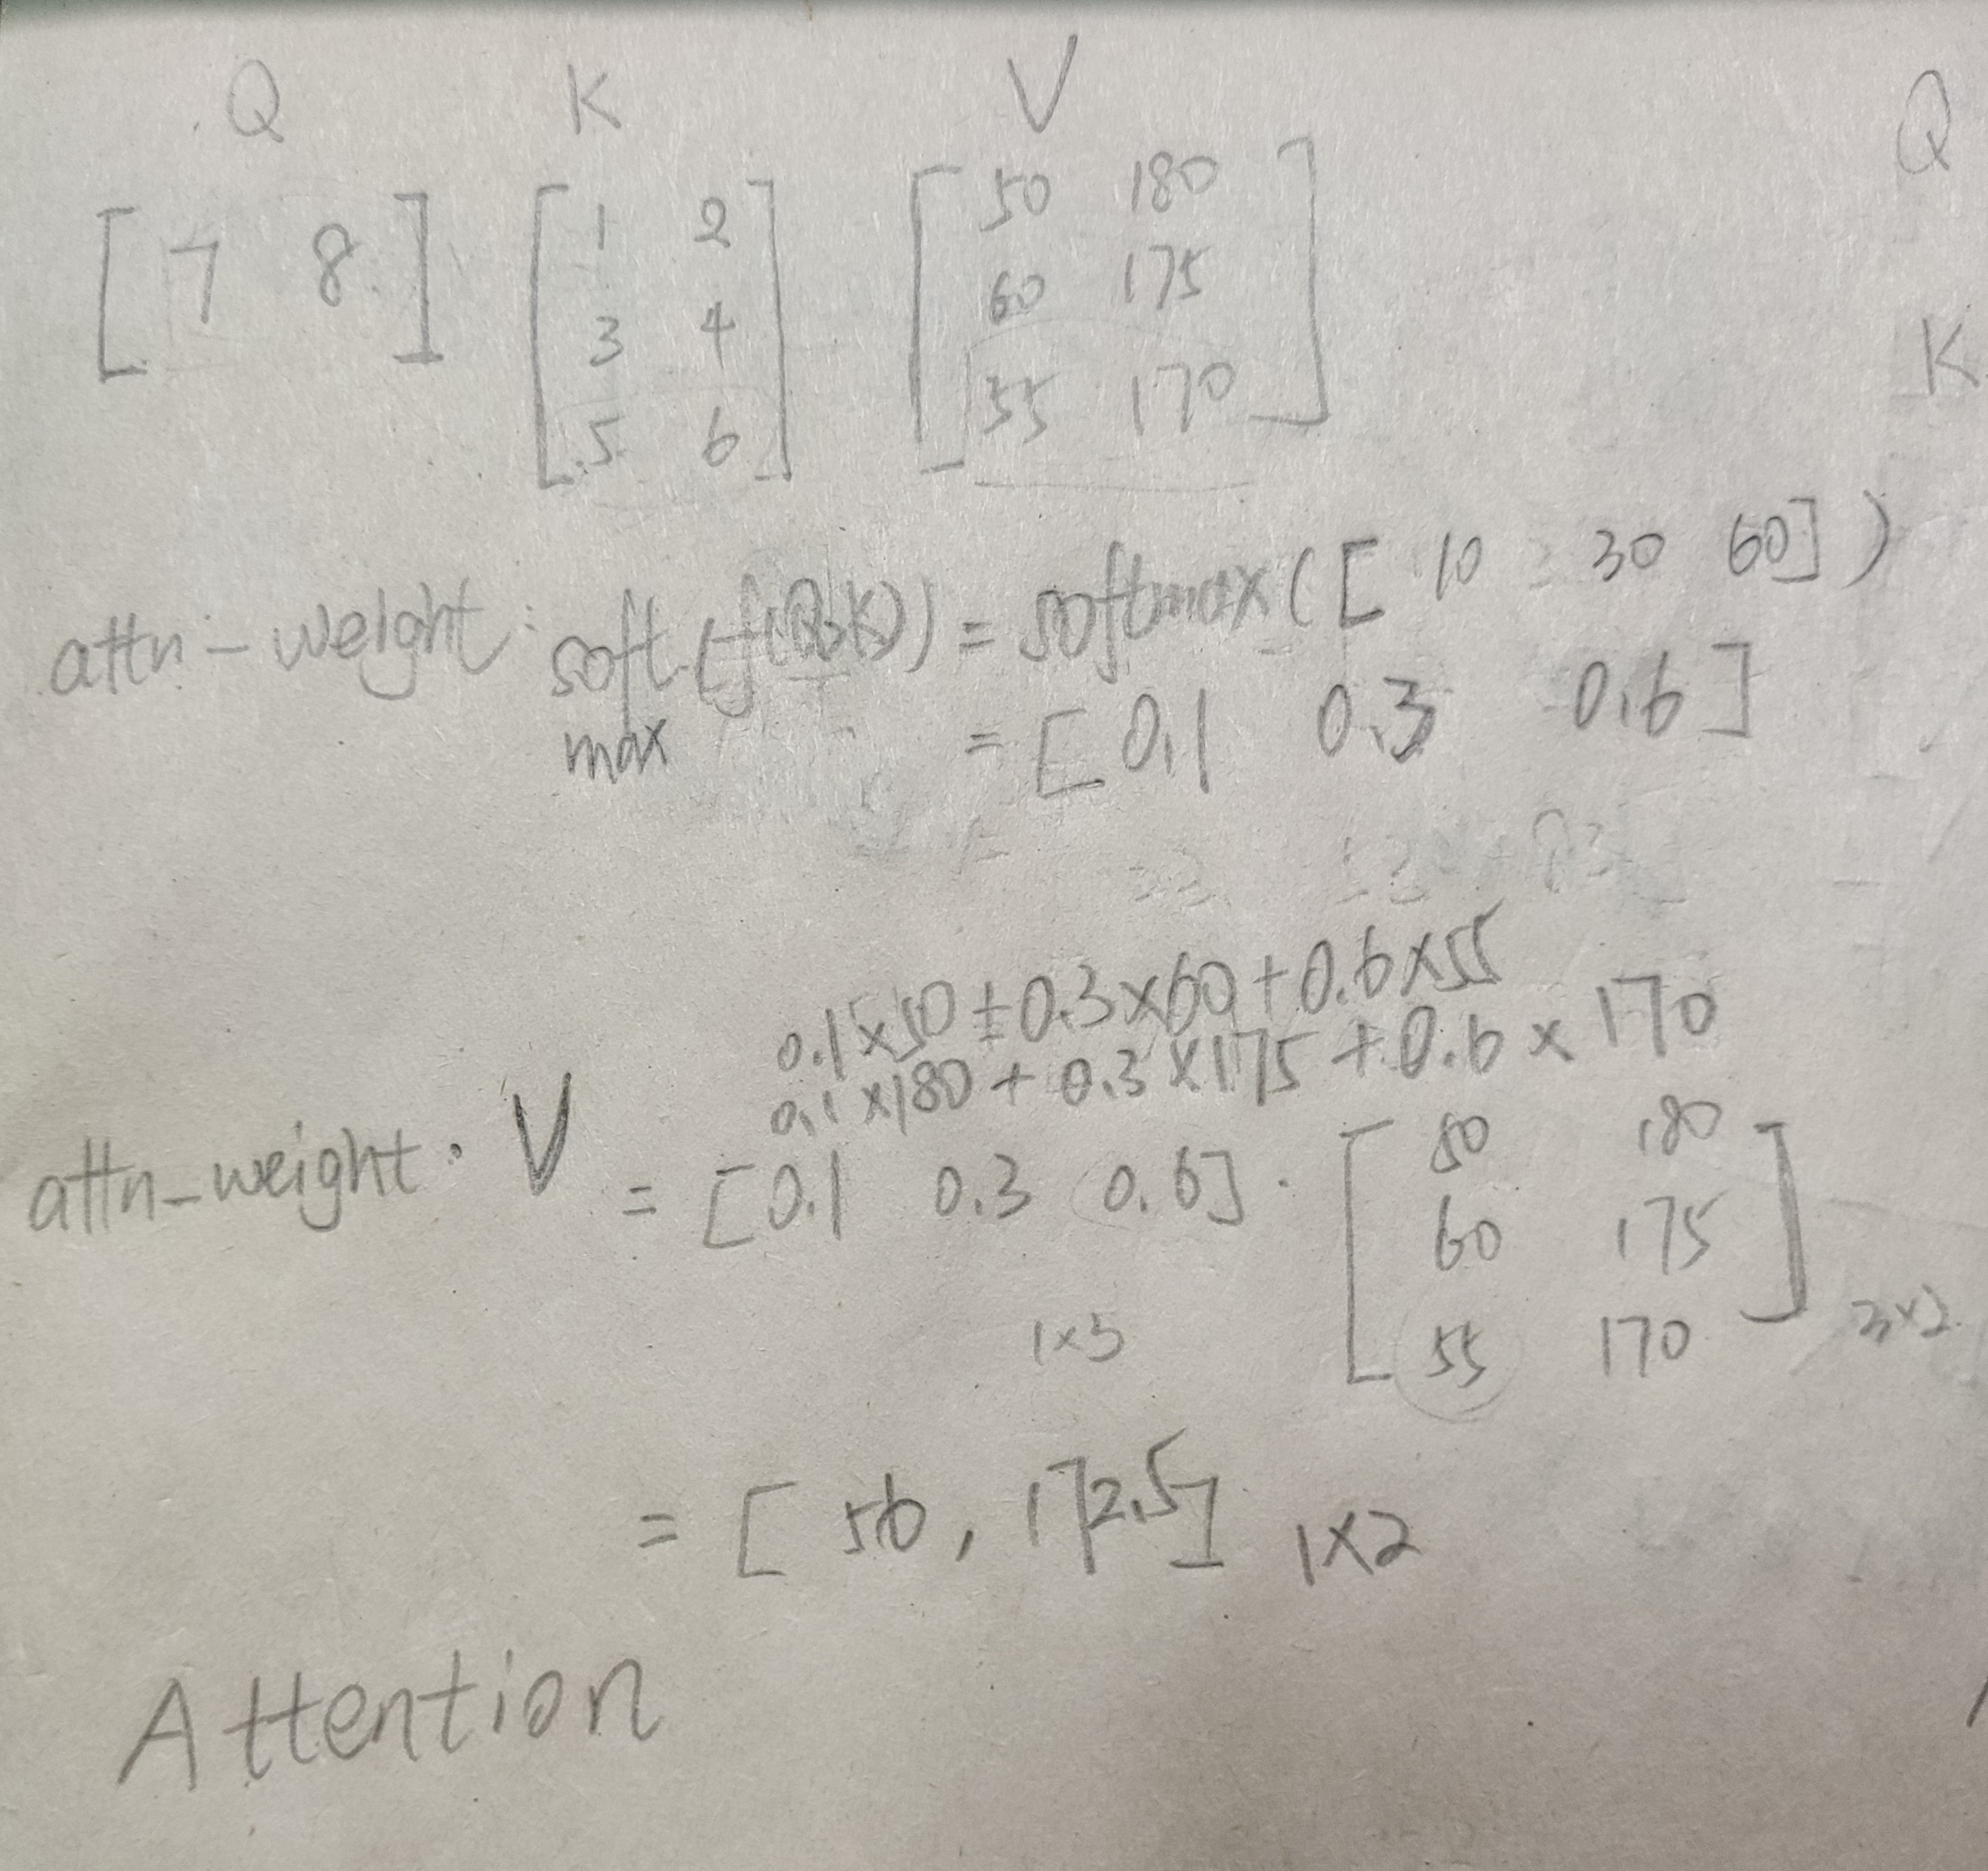

  其中 `f(Q, K)` 为计算 Q 和 K 相关性的函数，常见的有：
  - 点积（Dot Product）：$ f(Q, K) = QK^\top $
  - **缩放点积（Scaled Dot-Product）：$ f(Q, K) = \frac{QK^\top}{\sqrt{d_k}} $**
  - 加性注意力（Additive / Bahdanau）：$ f(Q, K) = v^\top \tanh(W_q Q + W_k K) $

- **Self-Attention 基本思想**  
  在前述 Attention 示例中，Q、K、V 可由人工设定；但在 Transformer 中，它们是**由同一个输入序列 $ \mathbf{X} $ 经“词嵌入 + 位置编码”后，分别通过可学习的线性投影（即矩阵乘法）生成的**，以 Query 为例：

  ![Q Projection](dfe6d43c26a2d653d78182bdbe935479.jpg)

  具体而言：
  $$
  \begin{aligned}
  \mathbf{X} &\in \mathbb{R}^{n \times d} \quad \text{（$n$：序列长度，$d$：嵌入维度）} \\
  \mathbf{Q} &= \mathbf{X}\mathbf{W}^Q, \quad \mathbf{W}^Q \in \mathbb{R}^{d \times d_k} \\
  \mathbf{K} &= \mathbf{X}\mathbf{W}^K, \quad \mathbf{W}^K \in \mathbb{R}^{d \times d_k} \\
  \mathbf{V} &= \mathbf{X}\mathbf{W}^V, \quad \mathbf{W}^V \in \mathbb{R}^{d \times d_v}
  \end{aligned}
  $$

  其中：
  - $\mathbf{W}^Q, \mathbf{W}^K, \mathbf{W}^V$ 为**可学习参数矩阵**（通常 $d_k = d_v = d$，多头时可不同）；
  - $\mathbf{X}$ 是词嵌入（Embedding）与位置编码（Positional Encoding）相加后的结果；
  - 因为 Q、K、V 均源自**同一输入 $\mathbf{X}$**，故称 **Self**-Attention。

- **Self Attention 具体实现 - Scaled Dot-Product Attention**  
  将前述 `f(Q, K)` 替换为**缩放点积（Scaled Dot-Product）** 形式，并结合 Self-Attention 的同源特性，即得论文中标准的 Scaled Dot-Product Attention。其完整计算流程为：

  $$
  \text{Attention}(\mathbf{Q}, \mathbf{K}, \mathbf{V}) = 
  \text{softmax}\left( \mathbf{M} \right (\frac{\mathbf{Q}\mathbf{K}^\top}{\sqrt{d_k}} )) \mathbf{V}
  $$

  其中：
  - $\mathbf{Q} \in \mathbb{R}^{n \times d_k}$, $\mathbf{K} \in \mathbb{R}^{n \times d_k}$, $\mathbf{V} \in \mathbb{R}^{n \times d_v}$；
  - **缩放因子 $\frac{1}{\sqrt{d_k}}$**：防止 $d_k$ 较大时点积结果过大，导致 softmax 梯度消失（因 softmax 在极大输入下趋于饱和）；
  - $\mathbf{M}$ 为**可选掩码矩阵**；
  - 最终输出为对 $\mathbf{V}$ 的加权求和，权重由 softmax 归一化后的注意力分数决定。

  ![Scaled Dot-Product Attention](scaled_dot_product_attention.jpg)

  > 💡 **为何需要缩放？**  
  > 当 $d_k$ 较大时，$\mathbf{Q}\mathbf{K}^\top$ 的方差增长为 $d_k$，导致 softmax 输入过大，梯度极小（接近 0）。缩放可使输入分布更稳定，利于训练深层模型。

- **Multi-Head Attention** 
  将输入通过多个独立的注意力头（heads）并行处理，使模型能**同时关注不同子空间的信息**（如语法、语义、位置等），最后拼接并投影输出。

  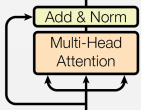

  具体流程：
  1. 对输入 $\mathbf{Q K V}$，分别用不同的可学习权重 $\mathbf{W}_i^Q, \mathbf{W}_i^K, \mathbf{W}_i^V$ 投影，得到第 $i$ 个头的 $\mathbf{Q}_i, \mathbf{K}_i, \mathbf{V}_i$；
  2. 每个头独立计算：$\text{head}_i = \text{ScaledDotProductAttention}(\mathbf{Q}_i, \mathbf{K}_i, \mathbf{V}_i)$；
  3. 拼接所有头输出：$\text{Concat}(\text{head}_1, \dots, \text{head}_h)$；
  4. 线性变换：$\text{MultiHead}(\mathbf{X}) = \text{Concat}(\text{heads}) \, \mathbf{W}^O$。
  5. 残差连接+归一化

  ![multi_head_attention](07897f7aa09f9e5173717bdc20982842.jpg)

- **Masked Multi-Head Attention**  

  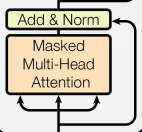

  专用于 Transformer **Decoder 的第一层**，在 Multi-Head Attention 基础上引入 **causal mask（因果掩码）**：  
  - 禁止每个位置关注其**未来位置**（即 $j > i$ 时屏蔽 $(i,j)$ 项）；  
  - 确保生成过程**自回归（auto-regressive）**，避免信息泄露；  
  - 掩码在 softmax 前以 $-\infty$ 添加，使对应权重归零。

  > 💡注意：Encoder 中不使用此掩码；Encoder-Decoder Attention 层使用 padding mask，但**不使用 causal mask**。

代码实现如下：

In [4]:
class ScaleDotProductAttention(nn.Module):
  '''
    得到每个token的V'，即每个单词的关注分
  '''
  def __init__(self, dropout=0.1):
    super().__init__()
    self.dropout = nn.Dropout(dropout)
  
  def forward(self, Q, K, V, mask=None):
    '''
      parmas:
        Q - Query [batch_size, seq_len, d_k]
        K - Key [batch_size, seq_len, d_k]
        V - Value [batch_size, seq_len, d_v]
        mask - 注意力掩码 [batch_size, num_heads, seq_len, seq_len] 或可以广播的形状
          mask中为 0 的位置表示“不应被注意”，比如：未来词
      return:
        output - 注意力输出 [batch_size, seq_len, d_v]
        attn_weights - 注意力权重 [batch_size, seq_len, seq_len]
    '''
    d_k = Q.size(-1)
    scores = torch.matmul(Q, K.transpose(-2, -1))/math.sqrt(d_k)   # [batch_size, seq_len, seq_len]
    if mask  is not None:
      scores = scores.masked_fill(mask == 0, -1e9)
    attn_weights = F.softmax(scores, dim=-1)
    attn_weights = self.dropout(attn_weights) # [batch_size, seq_len, seq_len]
    output = torch.matmul(attn_weights, V)    # [batch_size, seq_len, d_v]
    return output, attn_weights
  
class MultiHeadAttention(nn.Module):
  '''
    多头注意力机制，包含投影（不同线性变换改变QKV）
  '''
  def __init__(self, d_model, num_heads, dropout=0.1):
    super().__init__()
    assert d_model%num_heads == 0
    self.d_model = d_model
    self.num_heads = num_heads
    self.d_k = d_model//num_heads
    
    self.W_Q = nn.Linear(d_model, d_model, bias=False)
    self.W_K = nn.Linear(d_model, d_model, bias=False)
    self.W_V = nn.Linear(d_model, d_model, bias=False)
    self.W_O = nn.Linear(d_model, d_model, bias=False)
    
    self.attention = ScaleDotProductAttention(dropout)
    self.dropout = nn.Dropout(dropout)
    self.layer_norm = nn.LayerNorm(d_model)
  
  def forward(self, Q, K, V, mask=None):
    '''
      params:
        Q K V - 输入张量 [batch_size, seq_len, d_model]
        mask - 注意力掩码 [batch_size, seq_len, seq_len]
      return:
        output - 多头注意力输出 [batch_size, seq_len, d_model]
        attn_weights - 注意力权重 [batch_size, num_heads, seq_len, seq_len]
    '''
    batch_size = Q.size(0)
    q_len = Q.size(1)
    k_len = K.size(1)
    
    residual = Q
    Q_proj = self.W_Q(Q).view(batch_size, q_len, self.num_heads, self.d_k).transpose(1, 2)
    K_proj = self.W_K(K).view(batch_size, k_len, self.num_heads, self.d_k).transpose(1, 2)
    V_proj = self.W_V(V).view(batch_size, k_len, self.num_heads, self.d_k).transpose(1, 2)
    
    if mask is not None and mask.dim() == 3:
      mask = mask.unsqueeze(1)
    
    attn_output, attn_weights = self.attention(Q_proj, K_proj, V_proj, mask)
    attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, q_len, self.d_model)
    
    output = self.dropout(self.W_O(attn_output))
    output = self.layer_norm(output + residual)
    return output, attn_weights


#### 3. Feed Forward

  负责将数据进行升维处理特征后降维，为什么要这么做？增强非线性表达能力
  - 升维：将 512 维输入映射到 2048 维空间，在更高维空间中数据被“展开”，原本线性不可分的模式可能变得线性可分
  - 降维：将信息整合与压缩，去除冗余，聚焦关键特征

  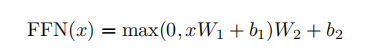

  ![feed_forward](e4f68641f86c710809a760b9515f55cd.jpg)

In [ ]:
class PositionwiseFeedForward(nn.Module):
  '''
    位置前馈网络，升维到d_ff  
    "The feed-forward layers transform the representations independently at each position."
  '''
  def __init__(self, d_model, d_ff, dropout=0.1):
    super().__init__()
    self.linear1 = nn.Linear(d_model, d_ff)
    self.linear2 = nn.Linear(d_ff, d_model)
    self.dropout = nn.Dropout(dropout)
    self.layer_norm = nn.LayerNorm(d_model)
    self.activation = nn.GELU()

  def forward(self, x):
    residual = x
    output = self.linear1(x)
    output = self.activation(output)
    output = self.dropout(output)
    output = self.linear2(output)
    output = self.dropout(output)
    output = self.layer_norm(output+residual)
    return output

### 二、Transformer结构  

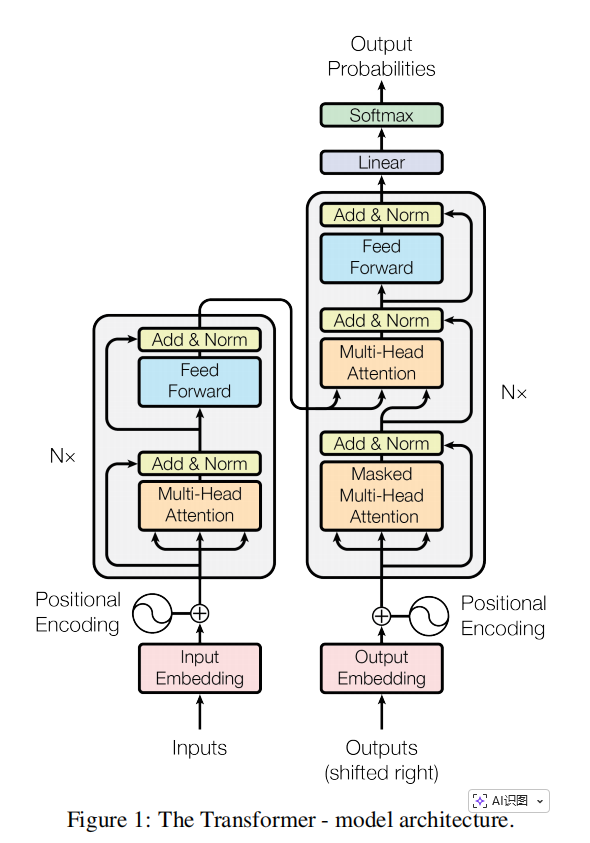  

主要结构：  
- Encoder
- Decoder

#### 1. Encoder  

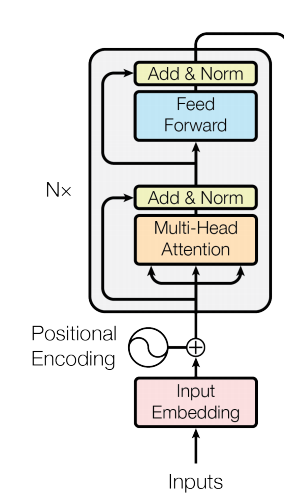

**输入**：  
- `x`：源语言 token IDs（含 `<bos>`, `<eos>`, `<pad>`），`[batch_size, seq_len]`

**输出**：  
- `output`：上下文感知的序列表示（Contextualized Embeddings），`[batch_size, seq_len, d_model]`  
- `all_attn_weights`：各层自注意力权重（可选返回），用于分析词间依赖关系

以 `x = [[1, 5, 8, 2, 0]]` 为例（`1=<bos>`, `5="ich"`, `8="liebe"`, `2=<eos>`, `0=<pad>`；`batch_size=1`, `seq_len=5`）：

- **step 1: word embeddings**  
  - 输入：`x: [1, 5]`  
  - 输出：`embeddings: [1, 5, d_model]`  
  - **作用**：将离散 token ID 映射为稠密语义向量，捕获词汇级语义相似性（如 `"liebe"` 与 `"liebt"` 向量接近）；`<pad>` 向量通常为零（因 `padding_idx=0`）。

- **step 2: positional embedding**  
  - 输入：`embeddings: [1, 5, d_model]`  
  - 输出：`positional: [1, 5, d_model]`  
  - **作用**：添加位置编码（如正弦/余弦函数或可学习 PE），注入序列顺序信息，克服 Self-Attention 的置换不变性。

- **step 3: encoder layer**  
  - 输入：`positional: [1, 5, d_model]`  
  - 输出：`output: [1, 5, d_model]`  
  - 子步骤：
    1. **自注意力（Self-Attention）**  
       - 输入：`x: [1, 5, d_model]`  
       - 输出：`attn_output: [1, 5, d_model]`, `attn_weights: [1, num_heads, 5, 5]`  
       - **作用**：  
         - 计算词与词之间的动态相关性（`attn_weights`）；  
         - 加权聚合全句信息，生成上下文增强表示（`attn_output`），使每个词“感知”整句语义。
    
    2. **前馈网络（Feed-Forward Network）**  
       - 输入：`attn_output: [1, 5, d_model]`  
       - 输出：`output: [1, 5, d_model]`  
       - **作用**：  
         - 对每个位置独立施加两层非线性变换（`Linear → ReLU → Linear`）；  
         - 弥补 Self-Attention 的线性局限，增强模型表达能力。
    
    3. **层归一化（Layer Normalization）**
       - 输入：`output: [1, 5, d_model]`  
       - 输出：`output: [1, 5, d_model]`  
       - **作用**：对每个样本的每个位置做归一化，稳定深层训练；配合残差连接可缓解梯度消失。

> **综上，Encoder 的作用**：  
> **将源语言离散符号序列转换为富含全局句法与语义依赖的上下文向量序列，为解码器提供结构化、位置感知的语义记忆**。




In [5]:
class EncoderLayer(nn.Module):
  '''
    编码器层/自注意层，包含多头注意力和前馈网络
  '''
  def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
    super().__init__()
    self.self_attention = MultiHeadAttention(d_model, num_heads, dropout)
    self.feed_forward = PositionwiseFeedForward(d_model, d_ff, dropout)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, mask=None):
    '''
      params:
        x - 输入张量[batch_size, seq_len, d_model]
        mask - 注意力掩码[batch_size, seq_len, seq_len]
      return:
        output - 编码器输出 [batch_size, seq_len, d_model]
        attn_weights - 注意力权重 [batch_size, num_heads, seq_len, seq_len]
    '''
    attn_output, attn_weights = self.self_attention(x, x, x, mask)
    output = self.feed_forward(attn_output)
    return output, attn_weights

class Transformer_Encoder(nn.Module):
  '''
    tranformer Encoder
  '''
  def __init__(self, vocab_size, d_model, num_layers, num_heads, d_ff,
               max_seq_length=512, dropout=0.1, padding_idx=0):
    super().__init__()
    self.d_model = d_model
    self.num_layers = num_layers

    self.word_embedding = WordEmbedding(vocab_size, d_model, padding_idx)
    self.position_embedding = PositionalEncoding(d_model, max_seq_length, dropout)
    self.attention_layers = nn.ModuleList([
      EncoderLayer(d_model, num_heads, d_ff, dropout)
      for _ in range(num_layers)
    ])
    self.layer_norm = nn.LayerNorm(d_model) # 输出层归一化（可选）

  def forward(self, x, mask=None):
    '''
      params:
        x: 输入token ids [batch_size, seq_len]
        mask: 注意力掩码 [batch_size, seq_len, seq_len]
      return:
        output: 编码器输出 [batch_size, seq_len, d_model]
        all_attn_weights: 所有层的注意力权重列表
    '''
    embeddings = self.word_embedding(x)
    x = self.position_embedding(embeddings)
    all_attn_weights = []
    for layer in self.attention_layers:
      x, attn_weights = layer(x, mask)
      all_attn_weights.append(attn_weights)
    output = self.layer_norm(x)
    return output, all_attn_weights

#### 2. Decoder  

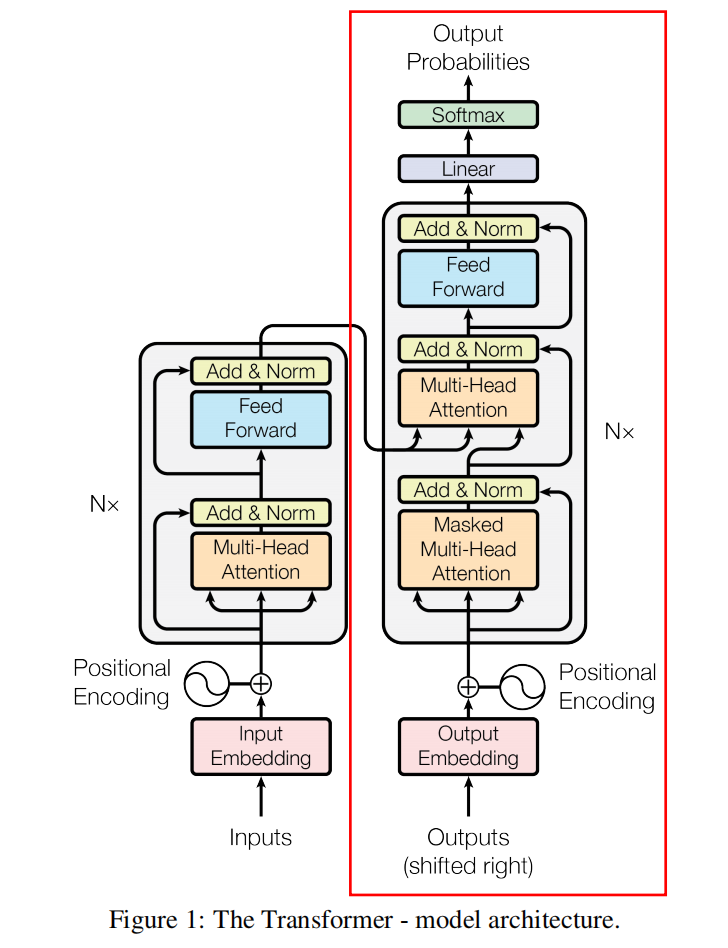

**输入**：  
- `tgt`：目标语言 token IDs（训练时为右移一位的真实目标序列），`[batch_size, tgt_seq_len]`  
- `encoder_output`：编码器输出的上下文表示，`[batch_size, src_seq_len, d_model]`  

**输出**：  
- `output`：词汇表上的 logits 分布（未归一化），`[batch_size, tgt_seq_len, vocab_size]`  
- `all_self_attn_weights`：各层自注意力权重  
- `all_cross_attn_weights`：各层交叉注意力权重（可用于可视化对齐）

以 `tgt = [[1, 10, 20, 2, 0]]` 为例（`1=<bos>`, `10="i"`, `20="love"`, `2=<eos>`, `0=<pad>`；`batch_size=1`, `tgt_seq_len=5`）：

- **step 1: word embeddings**  
  - 输入：`tgt: [1, 5]`  
  - 输出：`embeddings: [1, 5, d_model]`  
  - **作用**：将目标 token ID 映射为语义向量，建立与源端共享的语义空间。

- **step 2: positional embedding**  
  - 输入：`embeddings: [1, 5, d_model]`  
  - 输出：`positional: [1, 5, d_model]`  
  - **作用**：注入位置信息，使模型感知生成顺序（第1词、第2词…）。

- **step 3: decoder layer**  
  - 输入：`positional: [1, 5, d_model]` + `encoder_output: [1, src_len, d_model]`  
  - 输出：`output: [1, 5, d_model]`  
  - 子步骤：
    1. **掩码自注意力（Masked Self-Attention）**  
       - 输入：`x: [1, 5, d_model]`  
       - 输出：`self_attn_output: [1, 5, d_model]`, `self_attn_weights: [1, num_heads, 5, 5]`  
       - **作用**：  
         - 通过 **因果掩码（causal mask）** 确保位置 `t` 仅关注 `0..t`，防止未来信息泄露；  
         - 建模已生成词之间的时序依赖（如 `"i"` → `"love"` 的主谓关系）。
    
    2. **交叉注意力（Cross-Attention）**  
       - 输入：`self_attn_output: [1, 5, d_model]`, `encoder_output: [1, src_len, d_model]`  
       - 输出：`cross_attn_output: [1, 5, d_model]`, `cross_attn_weights: [1, num_heads, 5, src_len]`  

       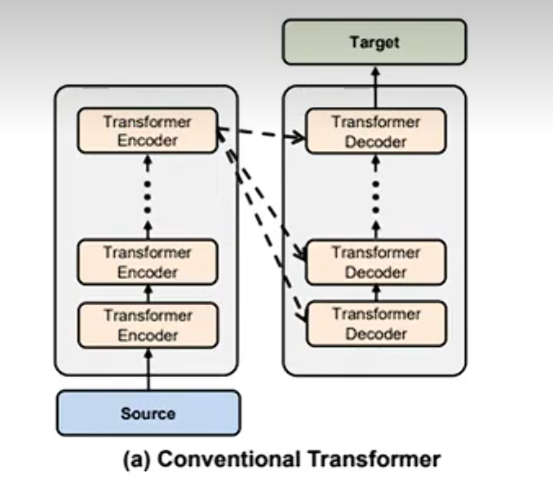
       
       - **作用**：  
         - Query 来自解码器当前状态，Key/Value 来自编码器输出；  
         - 实现 **目标词 ↔ 源句词的动态对齐**（如生成 `"love"` 时高亮 `"liebe"`）；  
         - 是跨语言信息传递的核心机制。
    
    3. **前馈网络 + 归一化**  
       - 输入：`cross_attn_output: [1, 5, d_model]`  
       - 输出：`output: [1, 5, d_model]`  
       - **作用**：  
         - 对每个位置独立进行非线性变换；  
         - 残差连接 + LayerNorm 以提升训练稳定性。

- **step 4: output projection**  
  - 输入：`x: [1, 5, d_model]`  
  - 输出：`logits: [1, 5, vocab_size]`  
  - **作用**：线性投影至词汇表维度，输出每个位置的下一词预测分布。

> **综上，Decoder 的作用**：  
> **以自回归方式逐步生成目标序列，通过掩码自注意力建模历史词依赖，通过交叉注意力动态检索源语言关键信息，最终输出符合上下文的词概率分布**。



In [ ]:
class DecoderLayer(nn.Module):
  '''
    解码器层，包含掩码多头自注意力、编码器-解码器注意力和前馈网络
  '''
  def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
    super().__init__()
    self.self_attention = MultiHeadAttention(d_model, num_heads, dropout)
    self.cross_attention = MultiHeadAttention(d_model, num_heads, dropout)
    self.feed_forward = PositionwiseFeedForward(d_model, d_ff, dropout)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, encoder_output, self_attention_mask=None, cross_attention_mask=None):
    """
    params:
      x - 解码器输入 [batch_size, tgt_seq_len, d_model]
      encoder_output - 编码器输出 [batch_size, src_seq_len, d_model]
      self_attention_mask - 解码器自注意力掩码 [batch_size, tgt_seq_len, tgt_seq_len]
      cross_attention_mask - 编码器-解码器注意力掩码 [batch_size, tgt_seq_len, src_seq_len]
    return:
      output - 解码器层输出 [batch_size, tgt_seq_len, d_model]
      self_attn_weights - 自注意力权重 [batch_size, num_heads, tgt_seq_len, tgt_seq_len]
      cross_attn_weights - 交叉注意力权重 [batch_size, num_heads, tgt_seq_len, src_seq_len]
    """
    self_attn_output, self_attn_weights = self.self_attention(
      x, x, x, mask=self_attention_mask
    ) # 掩码自注意力
    cross_attn_output, cross_attn_weights = self.cross_attention(
      self_attn_output, encoder_output, encoder_output, mask=cross_attention_mask
    ) # 编码器-解码器注意力
    output = self.feed_forward(cross_attn_output)
    return output, self_attn_weights, cross_attn_weights

class Transformer_Decoder(nn.Module):
  '''
    transformer decoder
  '''
  def __init__(self, vocab_size, d_model, num_layers, num_heads, d_ff,
               max_seq_length=512, dropout=0.1, padding_idx=0):
    super().__init__()
    self.d_model = d_model
    self.num_layers = num_layers

    self.word_embedding = WordEmbedding(vocab_size, d_model, padding_idx)
    self.position_embedding = PositionalEncoding(d_model, max_seq_length, dropout)
    self.decoder_layers = nn.ModuleList([
      DecoderLayer(d_model, num_heads, d_ff, dropout)
      for _ in range(num_layers)
    ])
    self.layer_norm = nn.LayerNorm(d_model)
    self.output_projection = nn.Linear(d_model, vocab_size)

  def forward(self, tgt, encoder_output, tgt_mask=None, memory_mask=None):
    '''
      params:
        tgt - 目标序列token ids [batch_size, tgt_seq_len]
        encoder_output - 编码器输出 [batch_size, src_seq_len, d_model]
        tgt_mask - 目标序列掩码（防止看到未来词）[batch_size, tgt_seq_len, tgt_seq_len]
        memory_mask - 编码器输出掩码 [batch_size, tgt_seq_len, src_seq_len]
      return:
        output - 解码器输出logits [batch_size, tgt_seq_len, vocab_size]
          output[b, t, :]对应基于tgt[b, :t+1]预测的第t+1个词分布
        all_self_attn_weights - 所有层的自注意力权重
        all_cross_attn_weights - 所有层的交叉注意力权重
    '''
    embeddings = self.word_embedding(tgt)
    x = self.position_embedding(embeddings)   # [batch_size, tgt_seq_len, d_model]
    all_self_attn_weights = []
    all_cross_attn_weights = []
    for layer in self.decoder_layers:
      x, self_attn_weights, cross_attn_weights = layer(
        x, encoder_output, tgt_mask, memory_mask
      )
      all_self_attn_weights.append(self_attn_weights)
      all_cross_attn_weights.append(cross_attn_weights)
    x = self.layer_norm(x)
    output = self.output_projection(x)
    return output, all_self_attn_weights, all_cross_attn_weights


#### 3. Transformer最终实现

In [ ]:
class Transformer(nn.Module):
  '''
    transformer(encoder-decoder)
  '''
  def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_layers, num_heads, d_ff,
               max_seq_length=512, dropout=0.1, padding_idx=0):
    '''
      params:
        src_vocab_size: int - 源语言（输入序列）的词汇表大小，包含特殊符号（如 <PAD>, <UNK>, <BOS>, <EOS>）
        tgt_vocab_size: int - 目标语言（输出序列）的词汇表大小
        d_model: int - 模型的隐藏层维度（512、1024）
        num_layers: int - 编码器/解码器层数
        num_heads: int - 多头注意力机制中的头数
        d_ff: int - 前馈网络的中间层维度
        max_seq_length: int - 支持的最大序列长度，决定位置编码矩阵的大小
        dropout: float - Dropout概率
        padding_idx: int - 填充符 <PAD> 对应的词索引
    '''
    super().__init__()
    self.d_model = d_model
    self.num_layers = num_layers

    self.encoder = Transformer_Encoder(
      vocab_size=src_vocab_size,
      d_model=d_model,
      num_layers=num_layers,
      num_heads=num_heads,
      d_ff=d_ff,
      max_seq_length=max_seq_length,
      dropout=dropout,
      padding_idx=padding_idx
    )
    self.decoder = Transformer_Decoder(
      vocab_size=tgt_vocab_size,
      d_model=d_model,
      num_layers=num_layers,
      num_heads=num_heads,
      d_ff=d_ff,
      max_seq_length=max_seq_length,
      dropout=dropout,
      padding_idx=padding_idx
    )

    # 共享权重（可选：编码器和解码器的词嵌入可以共享权重）
    # self.encoder.word_embedding.embedding.weight = self.decoder.word_embedding.embedding.weight

    self._init_weights()

  def _init_weights(self):
    # 使用Xavier初始化输出投影层
    nn.init.xavier_uniform_(self.decoder.output_projection.weight)
    if self.decoder.output_projection.bias is not None:
      nn.init.constant_(self.decoder.output_projection.bias, 0)

  def forward(self, src, tgt, src_mask=None, tgt_mask=None, memory_mask=None):
    '''
      params:
        src - 源序列token ids [batch_size, src_seq_len]
        tgt - 目标序列token ids [batch_size, tgt_seq_len]
        src_mask - 源序列掩码 [batch_size, src_seq_len, src_seq_len]
        tgt_mask - 目标序列掩码 [batch_size, tgt_seq_len, tgt_seq_len]
        memory_mask - 编码器-解码器注意力掩码 [batch_size, tgt_seq_len, src_seq_len]
      return:
        output - 解码器输出logits [batch_size, tgt_seq_len, tgt_vocab_size]
        encoder_output - 编码器输出 [batch_size, src_seq_len, d_model]
        all_encoder_attn_weights - 编码器注意力权重
        all_decoder_self_attn_weights - 解码器自注意力权重
        all_decoder_cross_attn_weights - 解码器交叉注意力权重
    '''
    encoder_output, all_encoder_attn_weights = self.encoder(src, src_mask)
    output, all_decoder_self_attn_weights, all_decoder_cross_attn_weights = self.decoder(
      tgt, encoder_output, tgt_mask, memory_mask
    )
    return output, encoder_output, all_encoder_attn_weights, all_decoder_self_attn_weights, all_decoder_cross_attn_weights

  def encode(self, src, src_mask=None):
    """仅运行编码器"""
    return self.encoder(src, src_mask)

  def decode(self, tgt, encoder_output, tgt_mask=None, memory_mask=None):
    """仅运行解码器"""
    return self.decoder(tgt, encoder_output, tgt_mask, memory_mask)

### 三、Transformer应用  

选择简单的`德译英`的神经机器翻译（NMT）任务，通过训练正确翻译德语。

训练集 - example
测试集 - test_example

- 准备流程：
  1. 将所有德语、英语句子中的单词进行编号，得到`src_vocab`和`tgt_vocab`词表
  2. 将训练集中的句子使用词表进行token ids编码，得到`src_batch`和`tgt_batch`

- 推理流程：
  1. encoder提供源词库，包含了每个单词的含义
  2. decoder融合encoder提供的词库以及前t个单词提供的上下文信息对第t+1个单词进行预测，直到输出EOS为止

  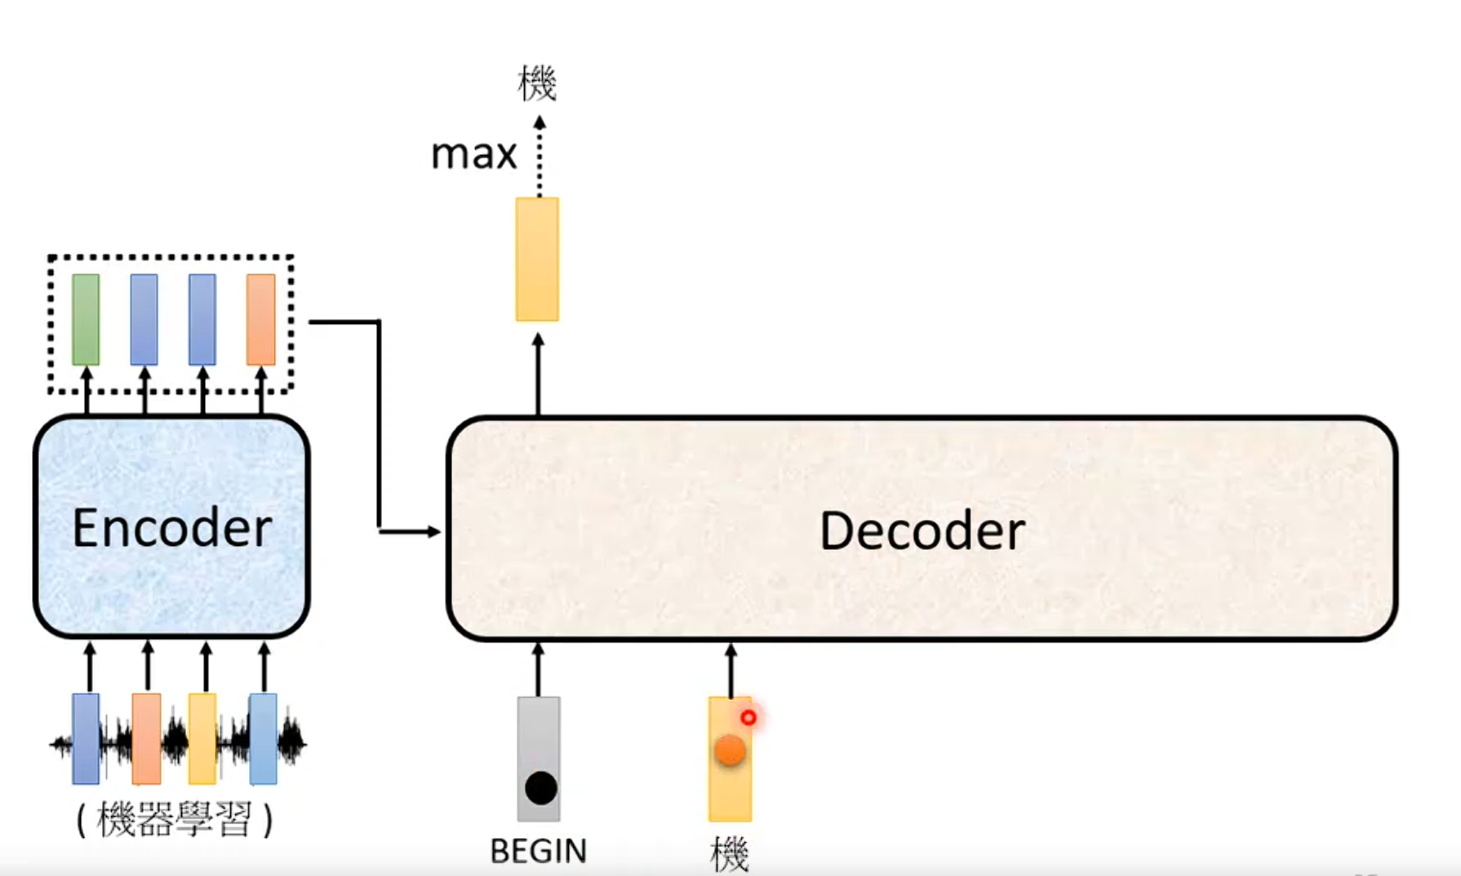

  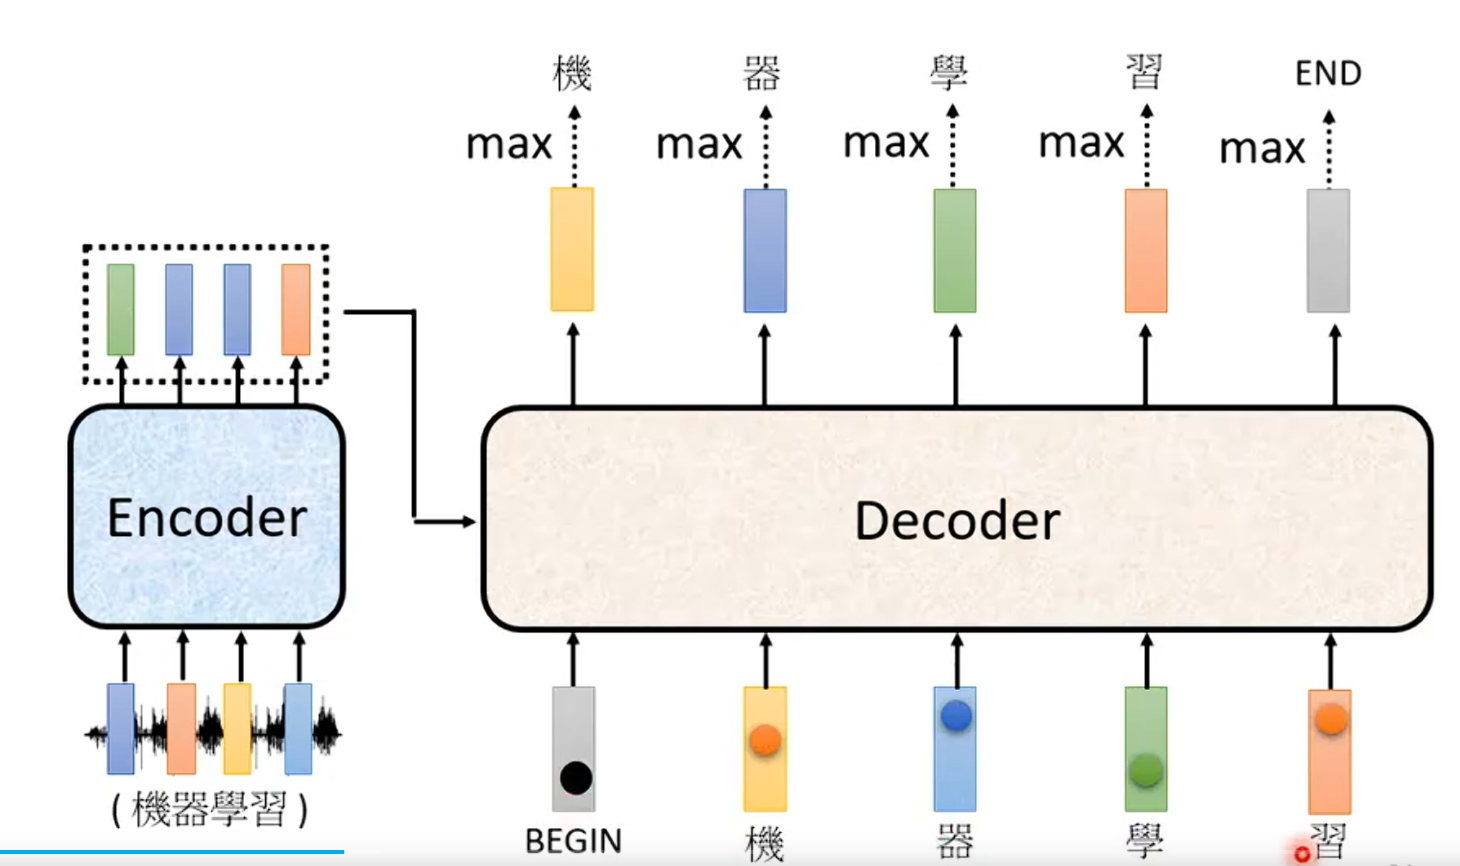

- 训练流程：
  通过教师强制的方式，将decoder根据前t个单词预测的第t+1个单词与真实的t+1个单词进行比较，计算损失值，更新模型

  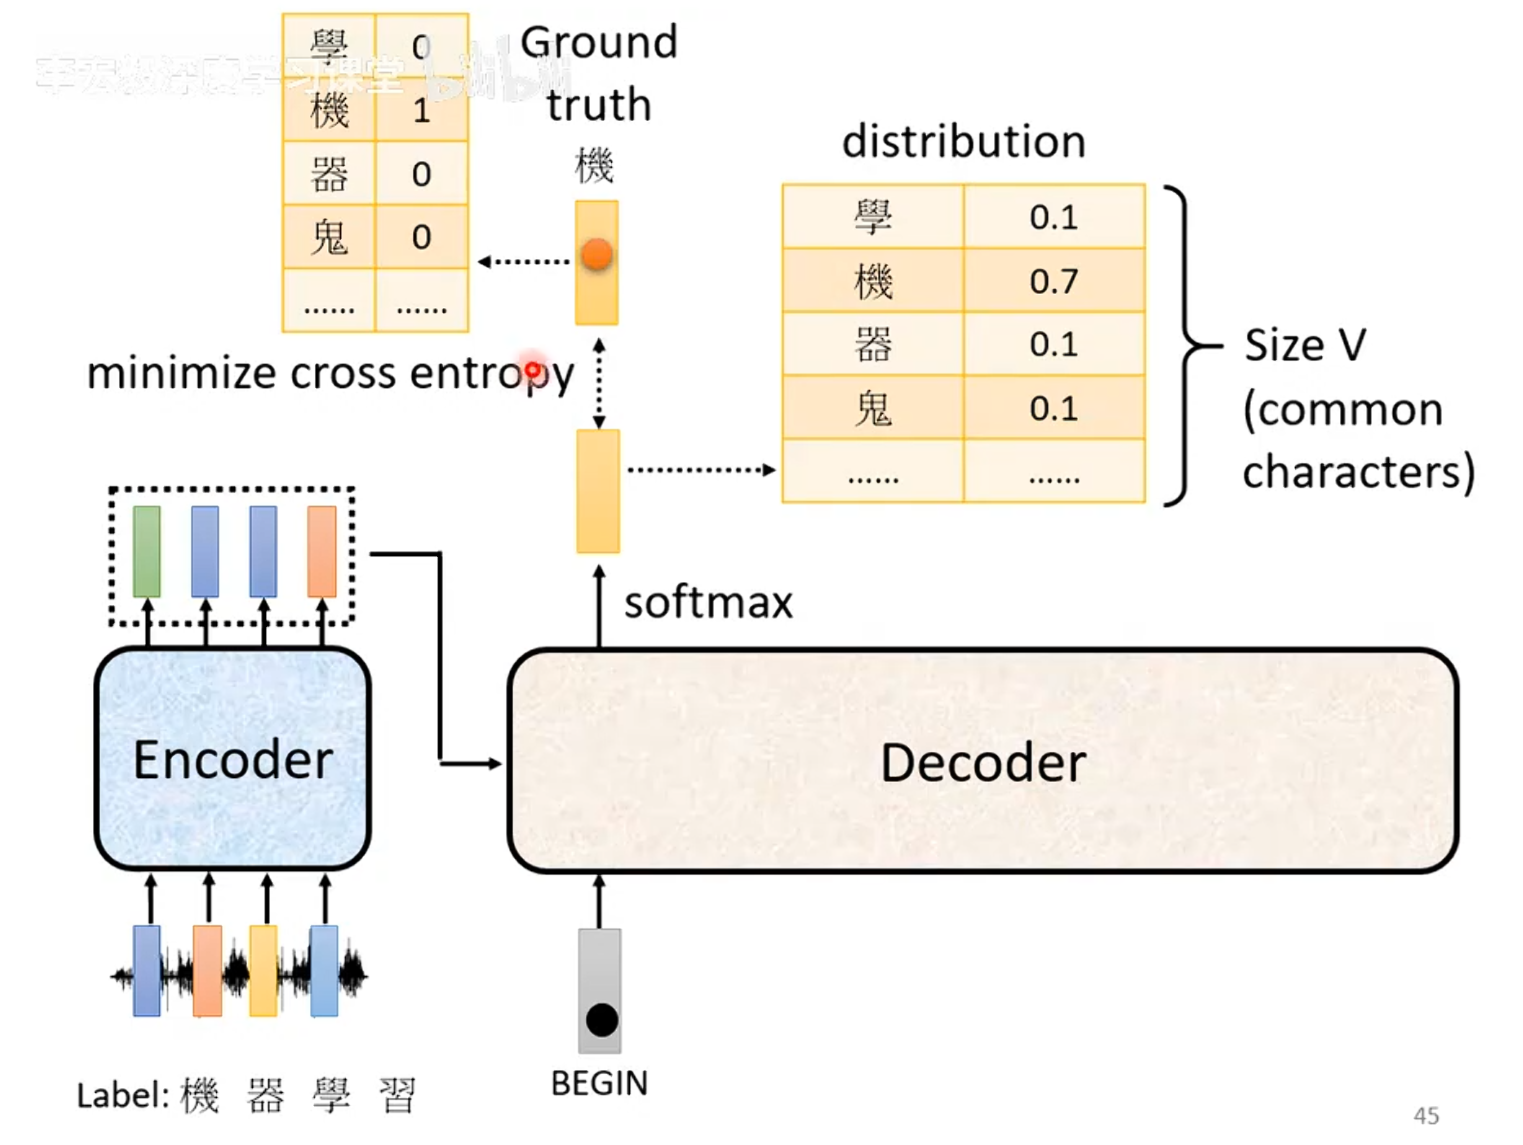



In [ ]:
def tokenize_and_encode(text, word2id, BOS=1, EOS=2, UNK=3, add_bos_eos=True):
  '''
    将句子转为 ID 序列（自动添加 bos/eos）
  '''
  ids = [word2id.get(w, UNK) for w in text.split()]
  if add_bos_eos:
    ids = [BOS]+ids+[EOS]
  return ids

def simple_transformer_example():
  examples = [
    ("ich spreche fließend englisch .", "i speak fluent english ."),
    ("wir sind im kino .", "we are in the cinema ."),
    ("das ist die toilette .", "this is the toilet ."),
    ("sie geht ins kino .", "she is going to the cinema ."),
    ("ich bin fließend .", "i am fluent ."),
    # ("wo ist das buch ?", "where is this book ?"),
    ("wir lieben dieses buch .", "we love this book ."),
    ("sie ist im kino .", "she is in the cinema ."),
    ("ich gehe ins kino .", "i am going to the cinema ."),
    ("das ist fließend englisch .", "this is fluent english ."),
    ("guten morgen , ich bin fließend .", "good morning , i am fluent ."),
    ("sie liebt dich .", "she loves you ."),
    ("das buch ist fließend .", "this book is fluent ."),
    ("ich liebe dieses buch .", "i love this book ."),
    ("sie liebt das buch .", "she loves the book ."),
    ("ich bin im buch .", "i am in the book ."),
    ("ist das buch fließend ?", "is this book fluent ?"),
    ("wo ist das kino ?", "where is the cinema ?"),
    # ("wo ist dieses kino ?", "where is this cinema ?"),
    ("wo ist das morgen ?", "where is the morning ?"),
    ("wo ist fließend englisch ?", "where is fluent english ?"),
    ("wo ist ich ?", "where is i ?"),
    ("wo ist wir ?", "where is we ?"),
    ("wo ist sie ?", "where is she ?"),
  ]
  test_examples = [
    ("wo ist das buch ?", "where is this book ?"),
    ("wo ist dieses kino ?", "where is this cinema ?"),
  ]
  PAD, BOS, EOS, UNK = 0, 1, 2, 3
  special_tokens = ["<pad>", "<bos>", "<eos>", "<unk>"]

  # 收集词汇
  src_words = set()
  tgt_words = set()
  for de, en in examples:
    src_words.update(de.split())
    tgt_words.update(en.split())
  src_vocab = special_tokens + sorted(src_words)    # 全部的德语（输入数据）
  tgt_vocab = special_tokens + sorted(tgt_words)    # 全部的英语（输出数据）
  print(f"🇩🇪 源词表大小: {len(src_vocab)} | 🇬🇧 目标词表大小: {len(tgt_vocab)}")

  src_word2id = {w: i for i, w in enumerate(src_vocab)}
  tgt_word2id = {w: i for i, w in enumerate(tgt_vocab)}
  tgt_id2word = {i: w for w, i in tgt_word2id.items()}
  src_seqs = [tokenize_and_encode(de, src_word2id) for de, _ in examples]   # 将所有德语句子用token ids表示
  tgt_seqs = [tokenize_and_encode(en, tgt_word2id) for _, en in examples]   # 将所有英语句子用token ids表示

  src_batch = pad_sequence([torch.tensor(s) for s in src_seqs], batch_first=True, padding_value=PAD).to(device)
  tgt_batch = pad_sequence([torch.tensor(t) for t in tgt_seqs], batch_first=True, padding_value=PAD).to(device)
  # 将所有token ids填充后表示
  # pad_sequence(..., batch_first=True, padding_value=PAD): 
  #     batch_first - 输出形状为 (batch_size, L_max)
  #     padding_value=PAD - 指定填充的数值（这里用 0 表示 <pad>）
  print(f'src={src_batch.shape}, tgt={tgt_batch.shape}')
  
  # 创建模型
  model = Transformer(
    src_vocab_size=len(src_vocab),
    tgt_vocab_size=len(tgt_vocab),
    d_model=256,
    num_layers=6,
    num_heads=8,
    d_ff=512,
    max_seq_length=20,
    dropout=0.1,
    padding_idx=PAD
  ).to(device)
  criterion = nn.CrossEntropyLoss(ignore_index=PAD)
  optimizer = optim.Adam(model.parameters(), lr=3e-4)

  # 训练过程
  model.train()
  for step in range(300):
    optimizer.zero_grad()
    
    # 构建掩码
    src_mask = UTools_createPaddingMask(src_batch, PAD).to(device)
    tgt_self_mask = UTools_createDecoderSelfAttentionMask(tgt_batch, PAD).to(device)
    cross_mask = UTools_createCrossAttentionMask(tgt_batch, src_batch, PAD).to(device)
    
    # 前向 → [B, T, V]
    logits, *_ = model(src_batch, tgt_batch, src_mask, tgt_self_mask, cross_mask)
    
    # 对齐：预测 tgt[i] ← tgt[:i]
    y_true = tgt_batch[:, 1:]       # <bos> w1 w2 ... <eos> → w1 w2 ... <eos>
    y_pred = logits[:, :-1, :]      # 预测长度需匹配
    # print(y_true, y_true.shape)
    
    loss = criterion(y_pred.reshape(-1, len(tgt_vocab)), y_true.reshape(-1))
    loss.backward()
    optimizer.step()
    
    print(f"Step {step+1:2d} | Loss: {loss.item():.4f}")

  # 推理过程
  model.eval()
  results = []
  with torch.no_grad():
    for i, (de_sent, en_ref) in enumerate(test_examples):
      # 编码源句
      src_ids = torch.tensor(tokenize_and_encode(de_sent, src_word2id)).unsqueeze(0).to(device)  # [1, L]
      src_mask = UTools_createPaddingMask(src_ids, PAD).to(device)
      enc_out, _ = model.encode(src_ids, src_mask)

      # 自回归生成
      tgt_input = torch.tensor([[BOS]]).to(device)  # 初始 <bos>
      generated = []

      for _ in range(15):  # 最大生成长度
        tgt_self_mask = UTools_createDecoderSelfAttentionMask(tgt_input, PAD).to(device)
        cross_mask = UTools_createCrossAttentionMask(tgt_input, src_ids, PAD).to(device)
        logits, *_ = model.decode(tgt_input, enc_out, tgt_self_mask, cross_mask)
        # print(logits, logits.shape)
        next_token = logits[0, -1].argmax().item()
        if next_token == EOS:
          break
        generated.append(next_token)
        tgt_input = torch.cat([tgt_input, torch.tensor([[next_token]]).to(device)], dim=1)

      # 解码为文本
      pred_words = [tgt_id2word.get(tid, '<unk>') for tid in generated]
      pred_sent = " ".join(pred_words)
      results.append((de_sent, en_ref, pred_sent))

  # ===== 对比展示 =====
  print("\n{:<25} | {:<30} | {:<30}".format("🇩🇪 德语输入", "🇬🇧 真实英语", "模型生成"))
  print("-" * 90)
  for de, ref, pred in results:
    # 清理标点前的空格（如 " ." → "."）
    ref = ref.replace(" .", ".").replace(" ?", "?").replace(" !", "!")
    pred = pred.replace(" .", ".").replace(" ?", "?").replace(" !", "!")
    print(f"{de:<25} | {ref:<30} | {pred:<30}")  

simple_transformer_example()

实验结果：

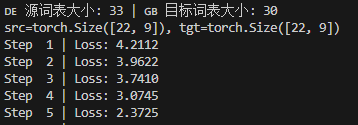

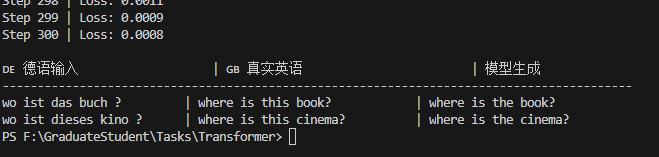

股票预测任务：
- 基于 PyTorch 的 nn.TransformerEncoder 实现，仅含编码器结构，通过自回归式单步预测 沪深A股历史K线 数据。

In [ ]:
#                             transformer.py
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class Transformer(nn.Module):
  def __init__(self, d_model=200, num_layers=2, dropout=0.1):
    '''
      params:
        d_model - Transformer 的模型隐藏维度
        num_layers - TransformerEncoderLayer 层数
        dropout - 防止过拟合的正则化率
    '''
    super().__init__()
    self.model_type = 'Transformer'

    self.src_mask = None
    self.pos_encoder = PositionalEncoding(d_model)
    self.encoder_layer = TransformerEncoderLayer(d_model=d_model, nhead=10, dropout=dropout)
    self.transformer_encoder = TransformerEncoder(self.encoder_layer, num_layers=num_layers)
    self.decoder = nn.Linear(d_model, 1)

    self._init_weights()

  def _init_weights(self):
    init_range = 0.1
    self.decoder.bias.data.zero_()
    self.decoder.weight.data.uniform_(-init_range, init_range)

  def forward(self, src):
    '''
      params:
        src - 向量 [seq_len, batch_size, feature_size]
    '''
    if self.src_mask is None or self.src_mask.size(0) != len(src):
      device = src.device
      mask = self._generate_square_subsequent_mask(len(src)).to(device)
      self.src_mask = mask

    src = self.pos_encoder(src)
    output = self.transformer_encoder(src, self.src_mask)
    output = self.decoder(output)
    return output
  
  def _generate_square_subsequent_mask(self, size):
    '''
      生成因果掩码： [[0, -inf, -inf, ...],
                    [0,   0,  -inf, ...],
                    [0,   0,    0, ...],
                    ...
                    ]
    '''
    mask = torch.tril(torch.ones(size, size) == 1) # Lower Triangular matrix
    mask = mask.float()
    mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
    mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0
    return mask

#                             train.py
def evaluate(model, data_source,criterion):
    model.eval() # Turn on the evaluation mode
    total_loss = 0.
    eval_batch_size = 1000
    with torch.no_grad():
        for i in range(0, len(data_source) - 1, eval_batch_size):
            data, targets = get_batch(data_source, i, eval_batch_size)
            output = model(data)
            total_loss = total_loss + len(data[0]) * criterion(output, targets).cpu().item()
    return total_loss / len(data_source)

def predict(model, sequences):
    start_timer = time.time()
    model.eval()
    predicted_seq = torch.Tensor(0)
    real_seq = torch.Tensor(0)
    with torch.no_grad():
        for i in range(0, len(sequences) - 1):
            data, target = get_batch(sequences, i, 1)
            output = model(data)
            predicted_seq = torch.cat((predicted_seq, output[-1].view(-1).cpu()), 0)
            real_seq = torch.cat((real_seq, target[-1].view(-1).cpu()), 0)
    timed = time.time() - start_timer
    print(f"{timed} sec")

    return predicted_seq, real_seq

#                             training.py
################################################################################
model = Transformer().to(device)
criterion = nn.MSELoss()
lr = 0.00005
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)
################################################################################

log_prices = log_features()
# log_features() - 从 股票日线（或分钟线）文件./datasets/sh.600000.csv 中
# 提取 对数收益率序列（log returns） ，作为后续模型的输入特征。

train_data, test_data = get_data(log_prices, 0.9)
# get_data(log_prices, 0.9) - 将原始的对数收益率序列（log returns）
# 预处理为适用于时序预测模型的训练/测试数据集。

################################################################################

N_EPOCHS = 150
for epoch in range(1, N_EPOCHS + 1):
    epoch_start_time = time.time()
    model.train()  # Turn on the evaluation mode
    total_loss = 0.0
    start_time = time.time()

    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):   # batch_size = 100
        data, targets = get_batch(train_data, i, batch_size)
        # get_batch() - 同 LSTM 分批操作
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 0.7)   # 梯度裁剪
        optimizer.step()

        total_loss = total_loss + loss.item()
        # 打印日志
        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches | "
                "lr {:02.10f} | {:5.2f} ms | "
                "loss {:5.7f}".format(
                    epoch,
                    batch,
                    len(train_data) // batch_size,
                    scheduler.get_last_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss,
                )
            )
            total_loss = 0
            start_time = time.time()

    if epoch % N_EPOCHS == 0:  # Valid model after last training epoch
        val_loss = evaluate(model, test_data, criterion=criterion)
        print("-" * 80)
        print(
            "| end of epoch {:3d} | time: {:5.2f}s | valid loss: {:5.7f}".format(
                epoch, (time.time() - epoch_start_time), val_loss
            )
        )
        print("-" * 80)

    else:
        print("-" * 80)
        print(
            "| end of epoch {:3d} | time: {:5.2f}s".format(
                epoch, (time.time() - epoch_start_time)
            )
        )
        print("-" * 80)

    scheduler.step()

torch.save(model, "saved_weights.pt")

#                             predict.py
model = torch.load("saved_weights.pt", weights_only=False)
log_prices = log_features()
train_data, test_data = get_data(log_prices, 0.9)
predicted_seq, real_seq = predict(model, test_data)

fig2, ax2 = plt.subplots(1, 1)

ax2.plot(predicted_seq, color='red', alpha=0.7)
ax2.plot(real_seq, color='blue', linewidth=0.7)
ax2.legend(['Actual', 'Forecast'])
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Log Prices')

fig2.tight_layout()
plt.show()

training:

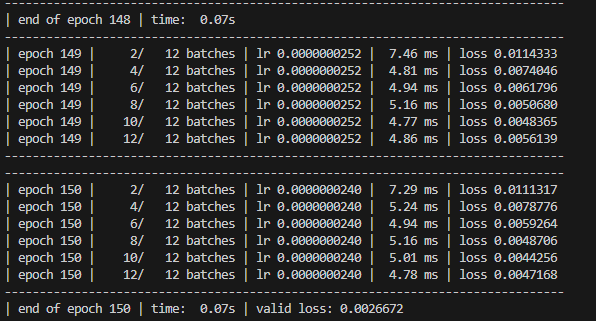

predict:

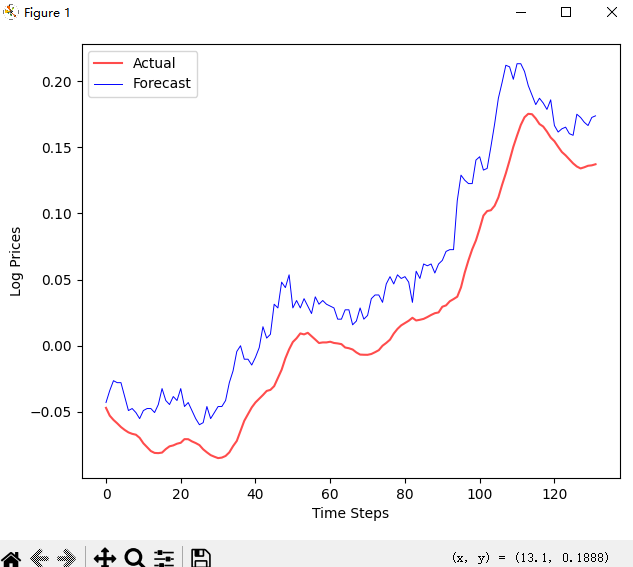
